In [11]:
import numpy as np
from scipy.integrate import solve_ivp

from simulator import OrbitSimulator
from plotting import *
import constants as const

def generate_reference_trajectory(s0: np.ndarray, t_span: tuple, dt: float) -> tuple:

    s0 = np.linalg.norm(s0)
    w = np.sqrt(const.MU_EARTH / s0**3)
    t_range = np.arange(t_span[0], t_span[1], dt)

    x = s0 * np.cos(w * t_range)
    y = s0 * np.sin(w * t_range)
    vx = -s0 * w * np.sin(w * t_range)
    vy = s0 * w * np.cos(w * t_range)

    results = np.column_stack([x, y, np.zeros_like(x), vx, vy, np.zeros_like(x)])

    return t_range, results

def generate_reference_trajectory(s0: np.ndarray, t_span: tuple, dt: float) -> tuple:
    def keplerian_rhs(t, s):
        r, v = s[:3], s[3:]
        a = -const.MU_EARTH / np.linalg.norm(r)**3 * r
        return np.hstack([v, a])
    
    times = np.arange(t_span[0], t_span[1], dt)
    sol = solve_ivp(fun=keplerian_rhs, t_span=t_span, y0=s0, t_eval=times, rtol=1e-9, atol=1e-12)
    return sol.t, sol.y.T



In [12]:
def run_full_simulation():
    print("--- Running Final Simulation with PD Controller (with Deadband) ---")

    duration_days = 1.0
    dt = 1.0 
    t_span = (0, duration_days * 24 * 3600)

    # These are our "true" parameters that we'll try to recover
    true_satellite_params = {'C_R': 1.5, 'A': 20.0, 'm': 1000.0}
    true_policy_params = {
        'gamma': 5000.0,
        'Kp': 5e-4,
        'Kd': 5e-1
    }
    true_sigma = 1e-4

    # Generate the data
    simulator = OrbitSimulator(
        satellite_params=true_satellite_params,
        policy_params=true_policy_params,
        sigma=true_sigma
    )
    ref_times, ref_states = generate_reference_trajectory(const.S0, t_span, dt)
    sim_times, sim_states, _ = simulator.simulate_SLV(const.S0, t_span, dt, ref_states)

    
    # Initialize and Run Simulator
    print("Initializing full simulator with 'true' parameters...")
    full_simulator = OrbitSimulator(
        satellite_params=true_satellite_params,
        policy_params=true_policy_params,
        sigma=true_sigma
    )
    
    print("Running simulation... (this may take a moment)")
    # UNPACK THE NEW RETURN VALUE: control_actions
    # full_simulator.simulate(const.S0, t_span, dt, ref_states)
    full_simulator.simulate_SLV(const.S0, t_span, dt, ref_states)


    df = full_simulator.get_log()

    
    print("Simulation complete.")


    plot2d(df)
    plot3d(df)
    plot_acceleration_components(log_df=df)
    # plot_controller_performance(log_df=df, policy_params=true_policy_params)
    plot_control_acceleration(log_df=df)
    plot_position_error(log_df=df, policy_params=true_policy_params)


    return df

--- Running Final Simulation with PD Controller (with Deadband) ---
Precomputing ephemeris data...
Initializing full simulator with 'true' parameters...
Running simulation... (this may take a moment)
Precomputing ephemeris data...
Simulation complete.


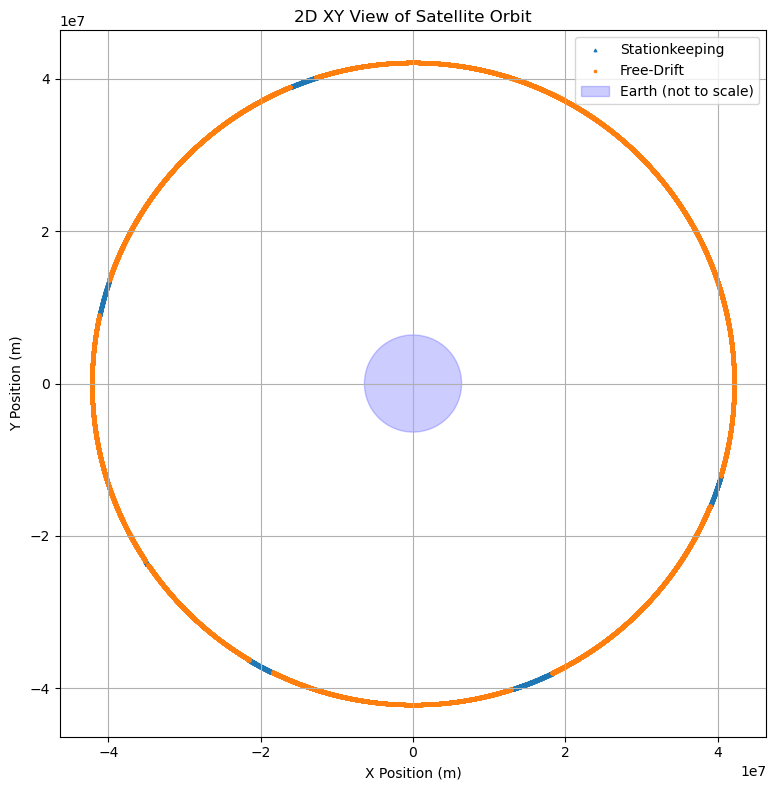

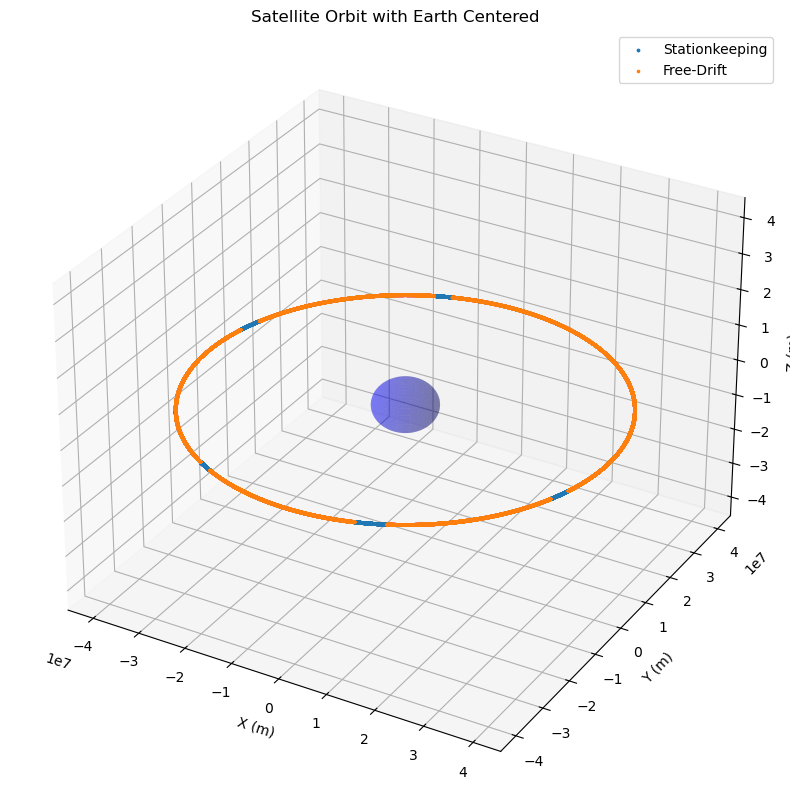

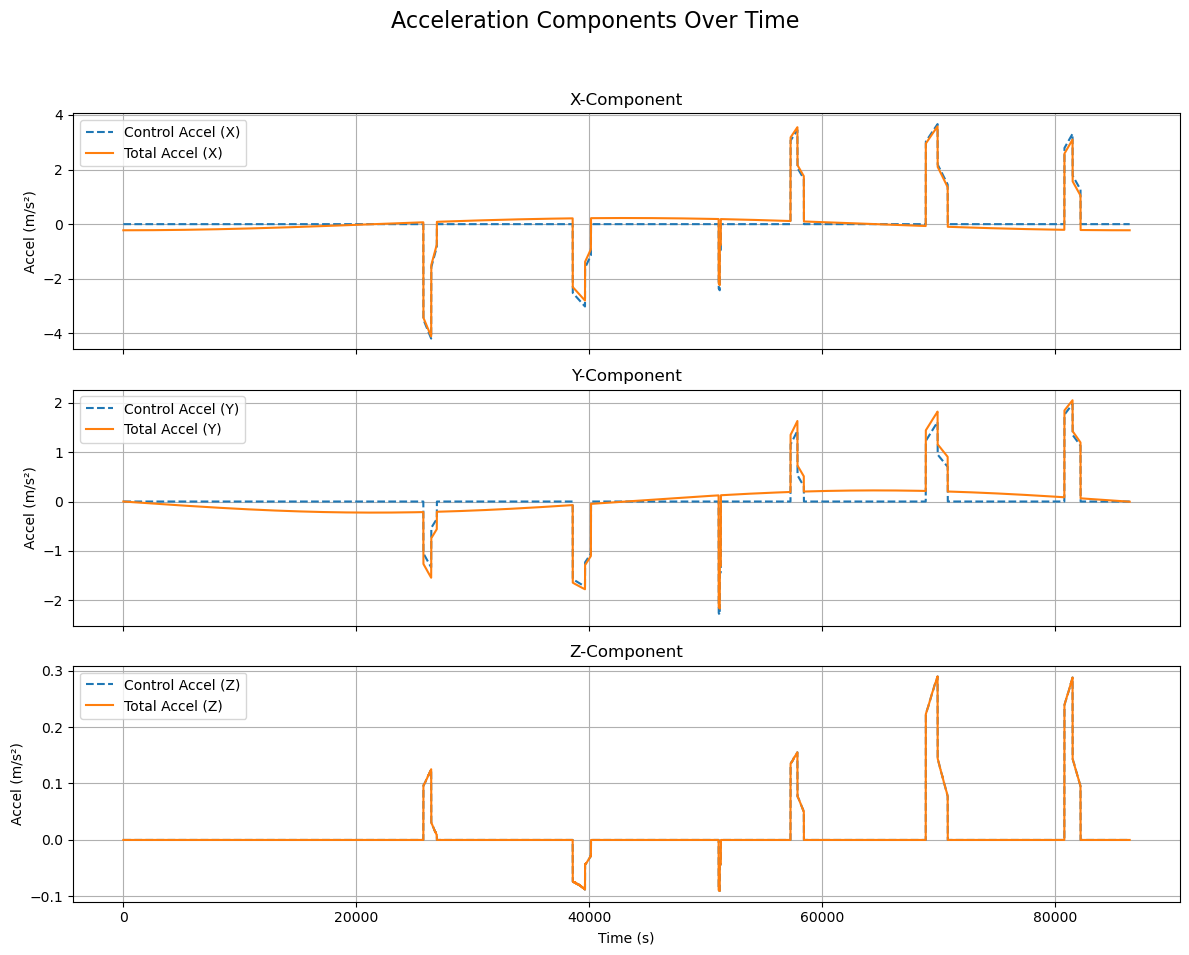

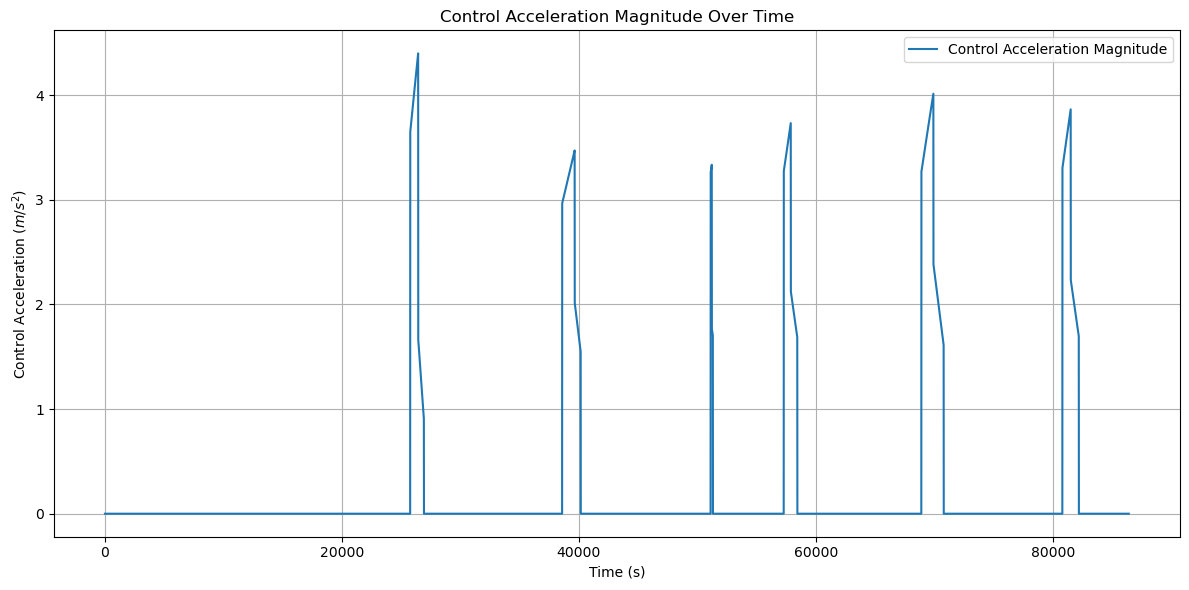

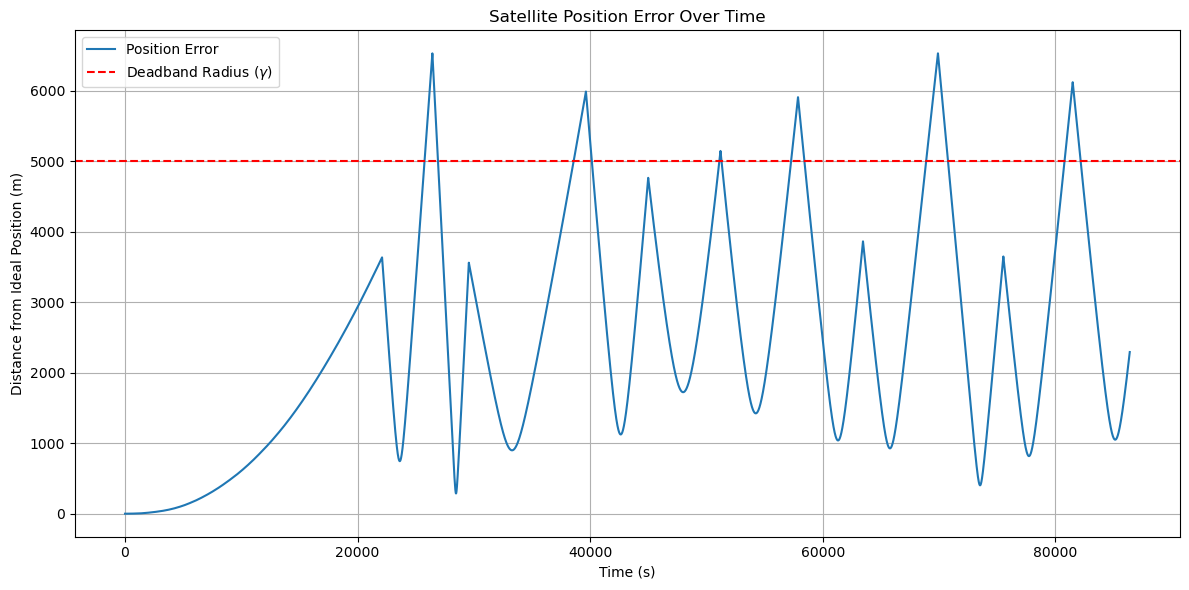

In [13]:
df = run_full_simulation()

In [4]:
df

,Time (s),Satellite ID,Longitude (deg),X (m),Y (m),Z (m),VX (m/s),VY (m/s),VZ (m/s),ideal X (m),...,ideal VX (m/s),ideal VY (m/s),ideal VZ (m/s),Status,Control Accel (X),Control Accel (Y),Control Accel (Z),Total Accel (X),Total Accel (Y),Total Accel (Z)
0,0.0,Geosat-1,0.000000,4.216414e+07,0.000000e+00,0.000000,0.000000,3074.661289,0.000000,4.216414e+07,...,-0.000000,3074.661285,0.0,non-stationkeeping,0.000000,0.000000,0.000000,-0.224221,-0.000004,-0.000002
1,1.0,Geosat-1,0.004178,4.216414e+07,3.074661e+03,0.000039,-0.224353,3074.661115,0.000078,4.216414e+07,...,-0.224208,3074.661277,0.0,non-stationkeeping,0.000000,0.000000,0.000000,-0.224221,-0.000020,-0.000002
2,2.0,Geosat-1,0.008356,4.216414e+07,6.149322e+03,0.000132,-0.448427,3074.661022,0.000109,4.216414e+07,...,-0.448416,3074.661252,0.0,non-stationkeeping,0.000000,0.000000,0.000000,-0.224221,-0.000037,-0.000002
3,3.0,Geosat-1,0.012534,4.216414e+07,9.223983e+03,0.000194,-0.672566,3074.660932,0.000016,4.216414e+07,...,-0.672624,3074.661211,0.0,non-stationkeeping,0.000000,0.000000,0.000000,-0.224221,-0.000053,-0.000002
4,4.0,Geosat-1,0.016712,4.216414e+07,1.229864e+04,0.000226,-0.896703,3074.660893,0.000047,4.216414e+07,...,-0.896832,3074.661154,0.0,non-stationkeeping,0.000000,0.000000,0.000000,-0.224221,-0.000070,-0.000002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259195,259195.0,Geosat-1,2.929373,4.210937e+07,2.154812e+06,2143.559407,-157.230747,3070.871444,0.013835,4.210874e+07,...,-157.555436,3070.621810,0.0,stationkeeping,-0.066295,0.578762,-0.214493,-0.290242,0.567272,-0.214509
259196,259196.0,Geosat-1,2.933551,4.210922e+07,2.157883e+06,2143.573169,-157.454713,3070.859743,0.013690,4.210858e+07,...,-157.779349,3070.610313,0.0,stationkeeping,-0.066326,0.578736,-0.214494,-0.290273,0.567233,-0.214509
259197,259197.0,Geosat-1,2.937730,4.210906e+07,2.160954e+06,2143.586857,-157.678541,3070.848209,0.013685,4.210843e+07,...,-158.003261,3070.598799,0.0,stationkeeping,-0.066358,0.578713,-0.214494,-0.290305,0.567191,-0.214510
259198,259198.0,Geosat-1,2.941908,4.210890e+07,2.164025e+06,2143.600540,-157.902389,3070.836701,0.013681,4.210827e+07,...,-158.227173,3070.587269,0.0,stationkeeping,-0.066391,0.578688,-0.214496,-0.290337,0.567150,-0.214511


In [16]:
0.02*0.02



0.0004